# Prediction of protein subcellular localisation - Jorge Martínez (M2BI)

## Load modules

In [42]:
import numpy as np
from pandas import read_csv

# Tensorflow and keras import
from keras import layers, models, utils, callbacks, optimizers

# # Utils to manipulate data
from keras.utils import to_categorical

# # Keras models
from keras.models import Sequential, Model

# # Keras layers
from keras.layers import Dense, Dropout
from keras.layers import Add, Permute
from keras.layers import Activation, Input
from keras.layers import Conv1D, MaxPooling1D, BatchNormalization, AveragePooling1D, Concatenate
from keras.layers import Flatten


# # Callback (for learning/optimize)
from keras.callbacks import EarlyStopping

# # Data analysis and protocol
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight


# # Plotting
import matplotlib.pyplot as plt
import seaborn as sns

## Load data and take a first look

In [43]:
# Load the data
train = np.load("../data/reduced_train.npz")
test = np.load("../data/reduced_val.npz")

# Create the x and y data for the train and test sets
x_train = train['X_train']
y_train = train['y_train']

x_test = test['X_val']
y_test = test['y_val']

# Basic Information
print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)

# Data Types
print("\nData types:")
print("x_train dtype:", x_train.dtype)
print("y_train dtype:", y_train.dtype)

# Missing Values
print("\nMissing values in x_train:", np.isnan(x_train).sum())
print("Missing values in y_train:", np.isnan(y_train).sum())

Shape of x_train: (2423, 400, 20)
Shape of y_train: (2423,)
Shape of x_test: (635, 400, 20)
Shape of y_test: (635,)

Data types:
x_train dtype: float32
y_train dtype: int32

Missing values in x_train: 0
Missing values in y_train: 0


In [44]:
# Sample Data
print("\nFirst 5 rows of x_train:")
print(x_train[:5])
print("\nFirst 5 rows of y_train:")
print(y_train[:5])


First 5 rows of x_train:
[[[0.   0.   0.   ... 0.   0.   0.  ]
  [1.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  ...
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]]

 [[0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.48 0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  ...
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]]

 [[0.   0.   0.   ... 0.   0.   0.  ]
  [1.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  ...
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]]

 [[0.   0.   0.   ... 0.   0.   0.  ]
  [1.   0.   0.   ... 0.   0.   0.  ]
  [1.   0.   0.   ... 0.   0.   0.  ]
  ...
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]]

 [[0.   0.   0.   ... 0.   0. 


Class distribution in y_train:
Class 0: 338 samples
Class 1: 567 samples
Class 2: 535 samples
Class 3: 233 samples
Class 4: 285 samples
Class 5: 63 samples
Class 6: 224 samples
Class 7: 59 samples
Class 8: 60 samples
Class 9: 59 samples


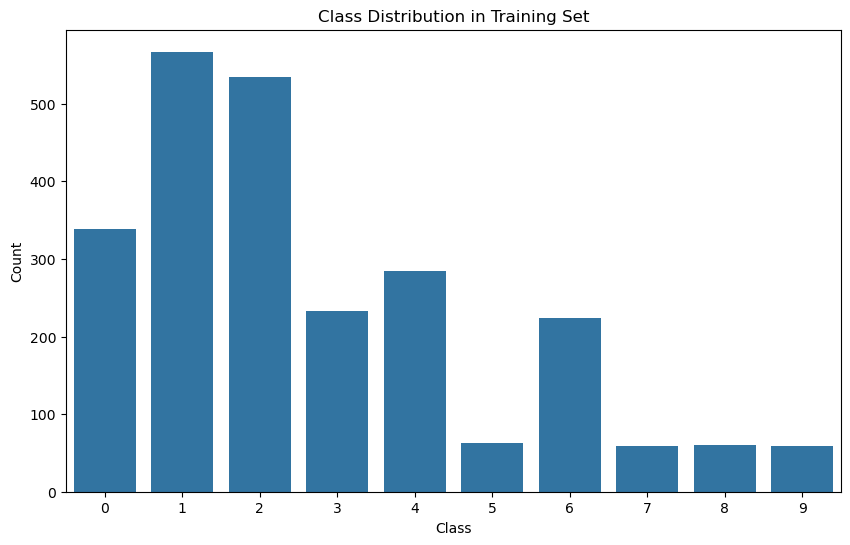

In [45]:
# Class Distribution
unique, counts = np.unique(y_train, return_counts=True)
print("\nClass distribution in y_train:")
for u, c in zip(unique, counts):
    print(f"Class {u}: {c} samples")
    
# Plot Class Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x=y_train)
plt.title("Class Distribution in Training Set")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [46]:
# One hot encoding
num_classes = len(np.unique(y_train))

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

## DNN

In [85]:
def dnn_model():
    model = Sequential([
        Input(shape=(400,20)),
        Flatten(),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation="softmax")
    ])
    
    model.compile(optimizer=optimizers.Adam(learning_rate=0.0005),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    
    return model

# Create the model 
model_dnn = dnn_model()
model_dnn.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_24 (Flatten)            │ (None, 8000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 32)             │       256,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 256,362 (1001.41 KB)

 Trainable params: 256,362 (1001.41 KB)

 Non-trainable params: 0 (0.00 B)

In [86]:
callback = callbacks.EarlyStopping(monitor = 'val_accuracy',
                                patience = 5,
                                mode = 'max',
                                restore_best_weights=True)

history_dnn = model_dnn.fit(x_train, y_train, 
                    epochs=80, 
                    batch_size=128, 
                    validation_split = 0.2)

Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1868 - loss: 2.2222 - val_accuracy: 0.3216 - val_loss: 2.0418
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3224 - loss: 1.9792 - val_accuracy: 0.3320 - val_loss: 1.9164
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3692 - loss: 1.8569 - val_accuracy: 0.3711 - val_loss: 1.8435
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4427 - loss: 1.6884 - val_accuracy: 0.4289 - val_loss: 1.7566
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4806 - loss: 1.6035 - val_accuracy: 0.4701 - val_loss: 1.6814
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5471 - loss: 1.4494 - val_accuracy: 0.4907 - val_loss: 1.6106
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5778 - loss: 1.3669 - val_accuracy: 0.4928 - val_loss: 1.5634
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6408 - loss: 1.2455 - val_accuracy: 0.5258 - val_loss

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step - accuracy: 0.7273 - loss: 0.9375
Test accuracy: 0.7276


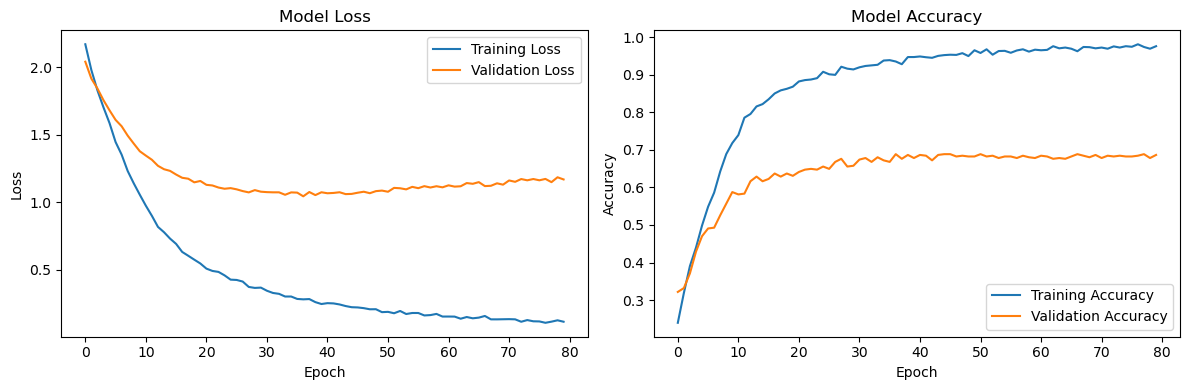

In [87]:
# Evaluate the model
test_loss_dnn, test_accuracy_dnn = model_dnn.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy_dnn:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_dnn.history['loss'], label='Training Loss')
plt.plot(history_dnn.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_dnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_dnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


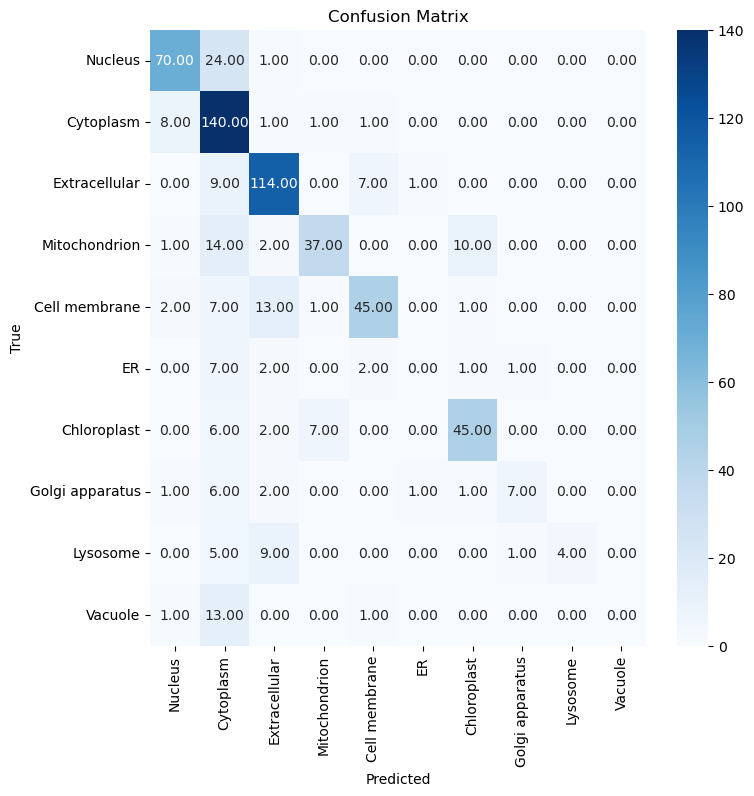

In [88]:
# Make predictions
y_pred = model_dnn.predict(x_test)


# Convert one-hot encoded labels back to class indices
y_test_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

classes = ['Nucleus','Cytoplasm','Extracellular','Mitochondrion','Cell membrane','ER',
           'Chloroplast','Golgi apparatus','Lysosome','Vacuole']

# Create confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## CNN

In [51]:
def cnn_model():
    model = Sequential([
        Input(shape=(400,20)),
        Conv1D(32,
               kernel_size=3,
               padding='same',
               activation='relu'),
        AveragePooling1D(pool_size=2),
        Dropout(0.5),
        BatchNormalization(),
        
        Conv1D(64,
               kernel_size=5,
               padding='same',
               activation='relu'),
        AveragePooling1D(pool_size=2),
        Dropout(0.5),
        BatchNormalization(),
        Flatten(),
        Dense(num_classes, activation="softmax")
    ])
    
    model.compile(optimizer=optimizers.Adam(learning_rate=0.0005),
                  loss="categorical_crossentropy", metrics=["accuracy"])
    
    return model

# Create the model
model_cnn = cnn_model()
model_cnn.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_21 (Conv1D)              │ (None, 400, 32)        │         1,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_9             │ (None, 200, 32)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 200, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 200, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_22 (Conv1D)              │ (None, 200, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_10            │ (None, 100, 64)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 100, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 10)             │        64,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,650 (299.41 KB)

 Trainable params: 76,458 (298.66 KB)

 Non-trainable params: 192 (768.00 B)

In [52]:
callback = callbacks.EarlyStopping(monitor = 'val_accuracy',
                                patience = 5,
                                mode = 'max',
                                restore_best_weights=True)   
history_cnn = model_cnn.fit(
    x_train, y_train,
    batch_size = 128,
    epochs = 80,
    validation_split=0.2)

Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.1936 - loss: 2.6769 - val_accuracy: 0.2351 - val_loss: 2.2344
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.3050 - loss: 2.1153 - val_accuracy: 0.2268 - val_loss: 2.2483
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.4260 - loss: 1.7752 - val_accuracy: 0.2412 - val_loss: 2.2648
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5037 - loss: 1.5459 - val_accuracy: 0.1876 - val_loss: 2.3214
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5294 - loss: 1.3721 - val_accuracy: 0.1155 - val_loss: 2.4034
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.6042 - loss: 1.2197 - val_accuracy: 0.0619 - val_loss: 2.4445
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6469 - loss: 1.0621 - val_accuracy: 0.1010 - val_loss: 2.4895
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6774 - loss: 0.9521 - val_accuracy: 0.2474 - v

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8292 - loss: 0.7054
Test accuracy: 0.8283


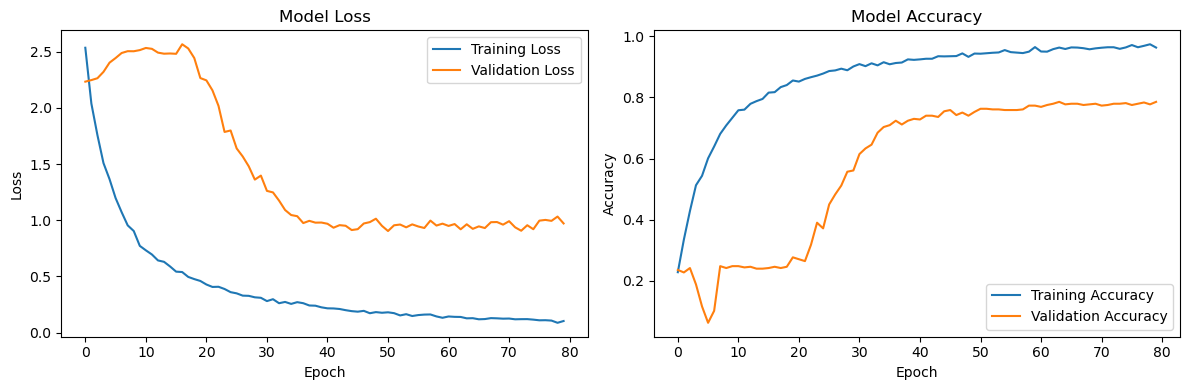

In [53]:
# Evaluate the model
test_loss_cnn, test_accuracy_cnn = model_cnn.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy_cnn:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


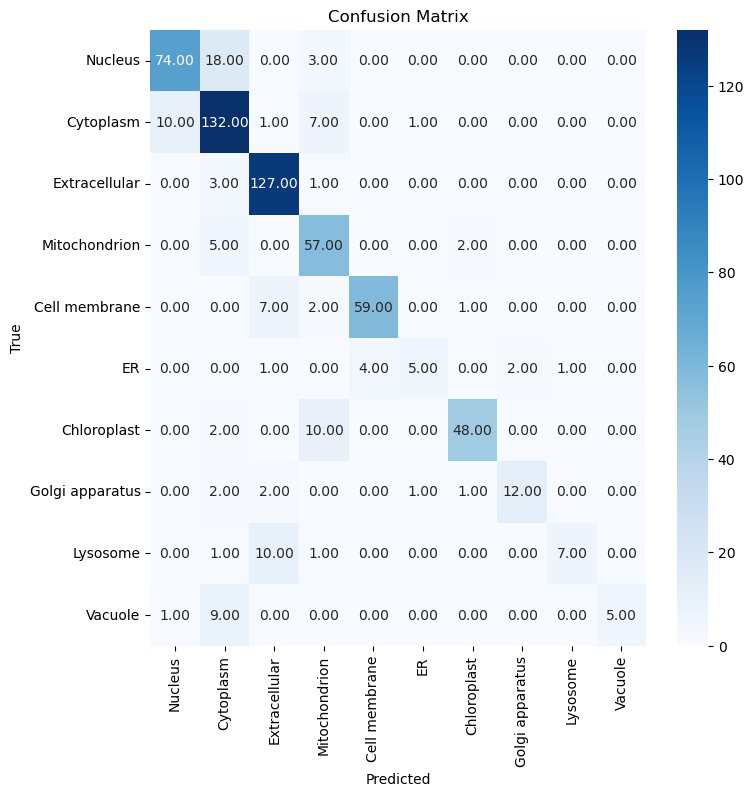

In [54]:
# Make predictions
y_pred = model_cnn.predict(x_test)

# Convert one-hot encoded labels back to class indices
y_test_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## CNN - functional API

In [55]:
def cnn_api_model():
    inputs = Input(shape=(400,20))
    x = Permute((2,1))(inputs)
    
    # Make two parallel convolutional layers with different kernel sizes
    conv_1 = Conv1D(32,
                    kernel_size=3,
                    padding="same",
                    activation="relu")(x)
    conv_2 = Conv1D(32,
                    kernel_size=5,
                    padding="same",
                    activation="relu")(x)
    
    convs = Concatenate(axis=1)([conv_1, conv_2])
    
    # Second simple convolutional layer
    conv_3 = Conv1D(64,
                    kernel_size=3,
                    padding="same",
                    activation="relu")(convs)
    
    # Reduce dimensions
    max_pool = MaxPooling1D(pool_size = 5)(conv_3)
    
    # Flatten to apply a dense layer
    flat = Flatten()(max_pool)
    dense = Dense(32, activation="relu")(flat)
    drop = Dropout(0.5)(dense)
    
    # Output layer
    outputs = Dense(num_classes, activation="softmax")(drop)
    
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizers.Adam(learning_rate=0.0005),
                  loss="categorical_crossentropy", metrics=["accuracy"])
    
    return model

# Create the model
model_cnn_api = cnn_api_model()
model_cnn_api.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 400, 20)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_3 (Permute) │ (None, 20, 400)   │          0 │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_23 (Conv1D)  │ (None, 20, 32)    │     38,432 │ permute_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_24 (Conv1D)  │ (None, 20, 32)    │     64,032 │ permute_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 40, 32)    │          0 │ conv1d_23[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_24[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_25 (Conv1D)  │ (None, 40, 64)    │      6,208 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 8, 64)     │          0 │ conv1d_25[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_14          │ (None, 512)       │          0 │ max_pooling1d_3[… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 32)        │     16,416 │ flatten_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 32)        │          0 │ dense_24[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 10)        │        330 │ dropout_18[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 125,418 (489.91 KB)

 Trainable params: 125,418 (489.91 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
callback = callbacks.EarlyStopping(monitor = 'val_accuracy',
                                patience = 5,
                                mode = 'max',
                                restore_best_weights=True)   
history_cnn_api = model_cnn_api.fit(
    x_train, y_train,
    batch_size = 128,
    epochs = 80,
    validation_split=0.2)

Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.1626 - loss: 2.2353 - val_accuracy: 0.2268 - val_loss: 2.1057
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1982 - loss: 2.1184 - val_accuracy: 0.3113 - val_loss: 2.0714
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2448 - loss: 2.0587 - val_accuracy: 0.2969 - val_loss: 2.0172
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2897 - loss: 1.9814 - val_accuracy: 0.2990 - val_loss: 1.9700
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2732 - loss: 1.9732 - val_accuracy: 0.3010 - val_loss: 1.9383
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3065 - loss: 1.9205 - val_accuracy: 0.3113 - val_loss: 1.9052
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3245 - loss: 1.8927 - val_accuracy: 0.3381 - val_loss: 1.8811
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3614 - loss: 1.8224 - val_accuracy: 0.3814 - v

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6927 - loss: 1.3383 
Test accuracy: 0.6929


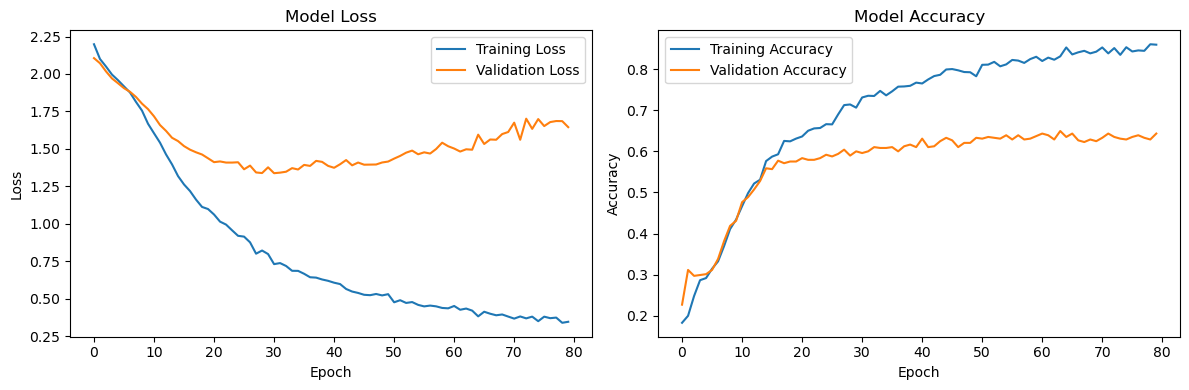

In [57]:
# Evaluate the model
test_loss_cnn_api, test_accuracy_cnn_api = model_cnn_api.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy_cnn_api:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_cnn_api.history['loss'], label='Training Loss')
plt.plot(history_cnn_api.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn_api.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn_api.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


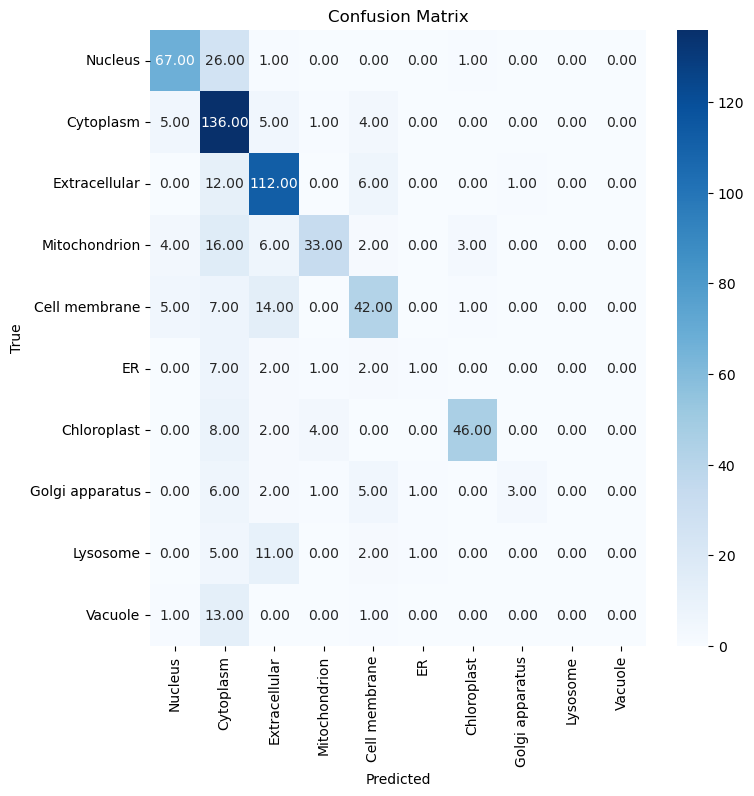

In [58]:
# Make predictions
y_pred = model_cnn_api.predict(x_test)

# Convert one-hot encoded labels back to class indices
y_test_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## ResNet

In [59]:
# Define the residual block achitecture
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(filters, kernel_size = 1)(x)
    
    # Second convolution layer
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(filters, kernel_size = kernel_size, 
               padding="same",
               strides = stride)(x)

    output = Add()([shortcut, x])
    return output

In [60]:
# Build the ResNet model
def resnet_model(input_shape=(400, 20), num_blocks=1):
    inputs = Input(shape=input_shape)
    
    residual_i = inputs
    
    for _ in range(num_blocks):
        residual_i = residual_block(residual_i, 20)
        
    gavg_1 = AveragePooling1D(2, strides=1)(residual_i)
    
    flat_1 = Flatten()(gavg_1)
    
    output = Dense(num_classes, activation="softmax")(flat_1)
    
    model = Model(inputs=inputs, outputs=output)
    
    model.compile(optimizer=optimizers.Adam(learning_rate=0.0005),
                  loss="categorical_crossentropy", metrics=["accuracy"])
                                                        
    return model

# Create the model
model_resnet = resnet_model()
model_resnet.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 400, 20)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 20)   │         80 │ input_layer_15[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 400, 20)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_26 (Conv1D)  │ (None, 400, 20)   │        420 │ activation_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 20)   │         80 │ conv1d_26[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 400, 20)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_27 (Conv1D)  │ (None, 400, 20)   │      1,220 │ activation_7[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 400, 20)   │          0 │ input_layer_15[0… │
│                     │                   │            │ conv1d_27[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling1d_… │ (None, 399, 20)   │          0 │ add_3[0][0]       │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_15          │ (None, 7980)      │          0 │ average_pooling1… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 10)        │     79,810 │ flatten_15[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 81,610 (318.79 KB)

 Trainable params: 81,530 (318.48 KB)

 Non-trainable params: 80 (320.00 B)

In [61]:
callback = callbacks.EarlyStopping(monitor = 'val_accuracy',
                                patience = 10,
                                mode = 'max',
                                restore_best_weights=True)   
history_resnet = model_resnet.fit(
    x_train, y_train,
    batch_size = 128,
    epochs = 80,
    validation_split=0.2)

Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.2418 - loss: 2.2343 - val_accuracy: 0.3546 - val_loss: 2.1882
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5109 - loss: 1.4731 - val_accuracy: 0.3753 - val_loss: 2.0790
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6676 - loss: 1.0876 - val_accuracy: 0.3629 - val_loss: 1.9923
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7916 - loss: 0.7922 - val_accuracy: 0.3485 - val_loss: 1.9264
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8694 - loss: 0.5666 - val_accuracy: 0.3340 - val_loss: 1.8732
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9044 - loss: 0.4657 - val_accuracy: 0.3196 - val_loss: 1.8576
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9416 - loss: 0.3478 - val_accuracy: 0.3113 - val_loss: 1.8513
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9609 - loss: 0.2664 - val_accuracy: 0.3155 - v

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7396 - loss: 1.2235
Test accuracy: 0.7417


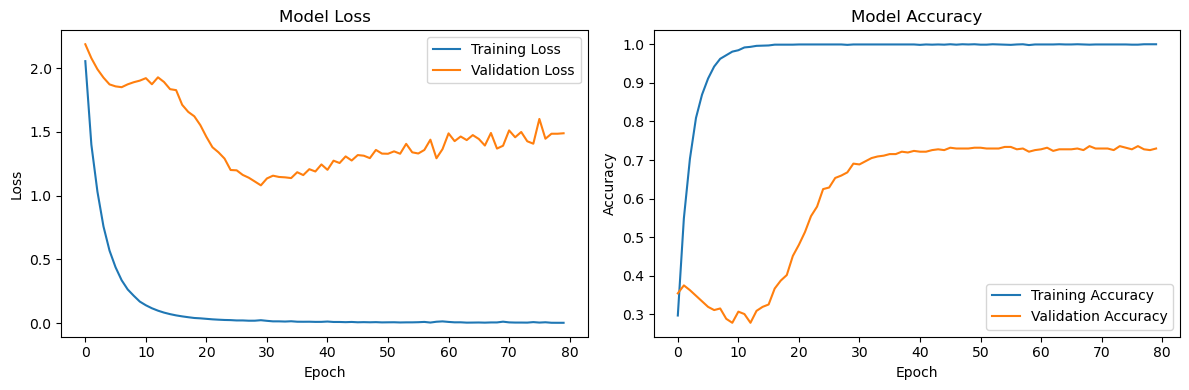

In [62]:
# Evaluate the model
test_loss_resnet, test_accuracy_resnet = model_resnet.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy_resnet:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_resnet.history['loss'], label='Training Loss')
plt.plot(history_resnet.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_resnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


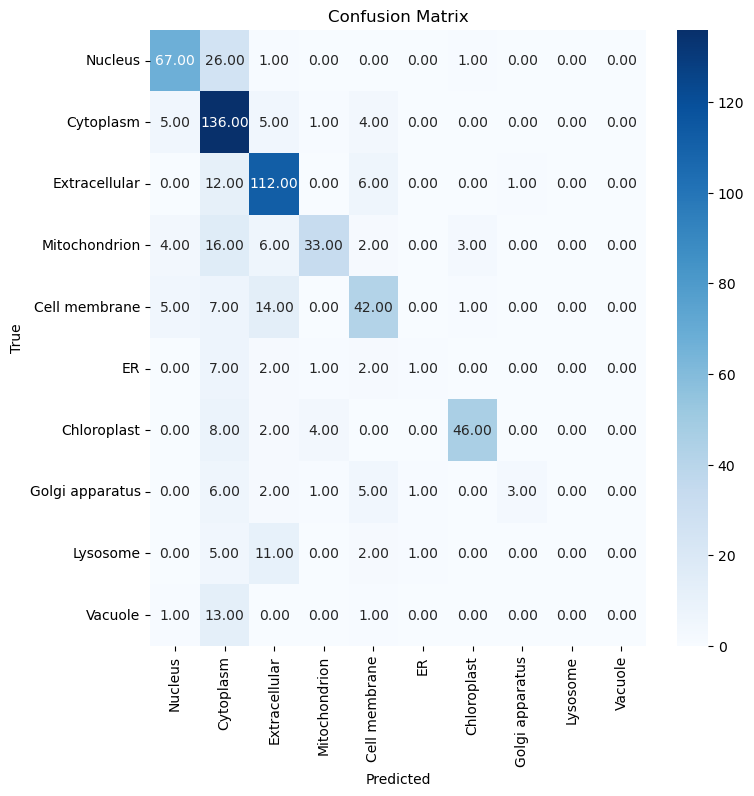

In [63]:
# Make predictions
y_pred = model_cnn_api.predict(x_test)

# Convert one-hot encoded labels back to class indices
y_test_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Include class weights

In [64]:
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(np.argmax(y_train, axis=1)),
                                        y = np.argmax(y_train, axis=1)
                                    )
class_weights = dict(enumerate(class_weights))
print(f'Class Weights: {class_weights}\n')

Class Weights: {0: 0.7168639053254438, 1: 0.427336860670194, 2: 0.45289719626168223, 3: 1.0399141630901287, 4: 0.8501754385964913, 5: 3.846031746031746, 6: 1.0816964285714286, 7: 4.106779661016949, 8: 4.038333333333333, 9: 4.106779661016949}



### DNN

In [89]:
# Create the model 
model_dnn_cw = dnn_model()

history_dnn_cw = model_dnn_cw.fit(x_train, y_train, 
                    epochs=80, 
                    batch_size=128, 
                    validation_split = 0.2,
                    class_weight=class_weights)

Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0813 - loss: 2.3154 - val_accuracy: 0.1340 - val_loss: 2.2654
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2276 - loss: 2.1534 - val_accuracy: 0.1340 - val_loss: 2.2335
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2375 - loss: 1.9758 - val_accuracy: 0.2722 - val_loss: 2.1535
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3084 - loss: 1.9051 - val_accuracy: 0.3649 - val_loss: 2.0506
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4268 - loss: 1.7494 - val_accuracy: 0.3649 - val_loss: 1.9813
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4737 - loss: 1.6532 - val_accuracy: 0.3856 - val_loss: 1.9257
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4873 - loss: 1.5516 - val_accuracy: 0.4144 - val_loss: 1.8605
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5449 - loss: 1.4151 - val_accuracy: 0.4907 - val_loss

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step - accuracy: 0.7368 - loss: 0.8146
Test accuracy: 0.7433


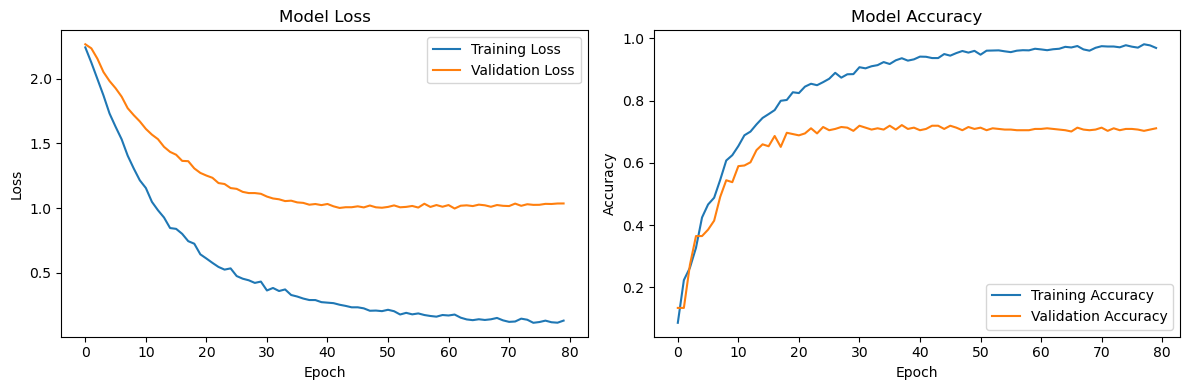

In [90]:
# Evaluate the model
test_loss_dnn_cw, test_accuracy_dnn_cw = model_dnn_cw.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy_dnn_cw:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_dnn_cw.history['loss'], label='Training Loss')
plt.plot(history_dnn_cw.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_dnn_cw.history['accuracy'], label='Training Accuracy')
plt.plot(history_dnn_cw.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

### CNN

In [67]:
model_cnn_cw = cnn_model()

history_cnn_cw = model_cnn_cw.fit(
    x_train, y_train,
    batch_size = 128,
    epochs = 80,
    validation_split=0.2,
    class_weight=class_weights)

Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.1188 - loss: 2.7374 - val_accuracy: 0.1175 - val_loss: 2.3123
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.2210 - loss: 2.4155 - val_accuracy: 0.0887 - val_loss: 2.3710
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.3028 - loss: 2.0602 - val_accuracy: 0.0639 - val_loss: 2.4584
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3840 - loss: 1.7440 - val_accuracy: 0.0763 - val_loss: 2.5388
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.3891 - loss: 1.6506 - val_accuracy: 0.0825 - val_loss: 2.6036
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.4814 - loss: 1.3979 - val_accuracy: 0.0268 - val_loss: 2.7180
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5023 - loss: 1.2832 - val_accuracy: 0.0412 - val_loss: 2.7972
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5272 - loss: 1.2472 - val_accuracy: 0.0474 - v

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8161 - loss: 0.6719
Test accuracy: 0.8252


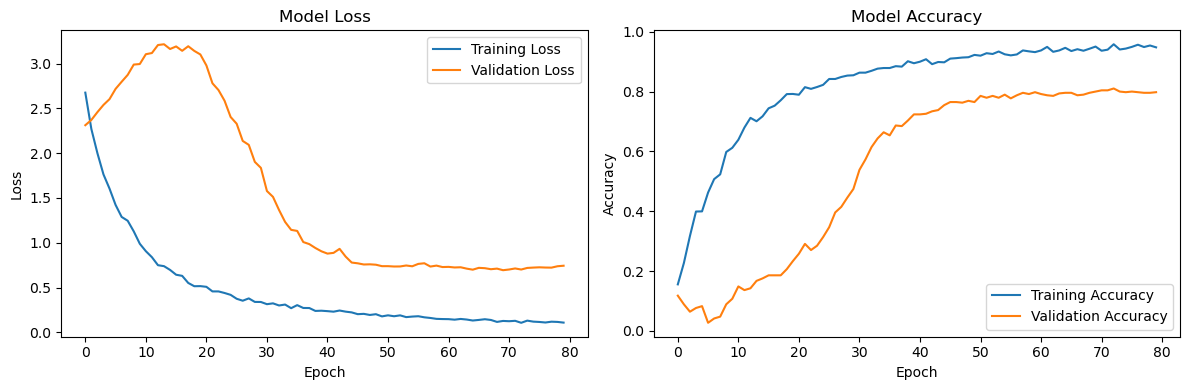

In [68]:
# Evaluate the model
test_loss_cnn_cw, test_accuracy_cnn_cw = model_cnn_cw.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy_cnn_cw:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_cnn_cw.history['loss'], label='Training Loss')
plt.plot(history_cnn_cw.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn_cw.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn_cw.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

### CNN - functional API

In [69]:
model_cnn_api_cw = cnn_api_model()
history_cnn_api_cw = model_cnn_api_cw.fit(
    x_train, y_train,
    batch_size = 128,
    epochs = 80,
    validation_split=0.2,
    class_weight=class_weights)

Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.1042 - loss: 2.2373 - val_accuracy: 0.2371 - val_loss: 2.2764
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1658 - loss: 2.2066 - val_accuracy: 0.1649 - val_loss: 2.2723
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1815 - loss: 2.1515 - val_accuracy: 0.2866 - val_loss: 2.2262
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2153 - loss: 2.1120 - val_accuracy: 0.3052 - val_loss: 2.1979
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2059 - loss: 2.1729 - val_accuracy: 0.3175 - val_loss: 2.1589
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2264 - loss: 1.9578 - val_accuracy: 0.2969 - val_loss: 2.1597
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2559 - loss: 2.0394 - val_accuracy: 0.3237 - val_loss: 2.0971
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2846 - loss: 1.9905 - val_accuracy: 0.3340 - v

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6890 - loss: 1.2445 
Test accuracy: 0.6913


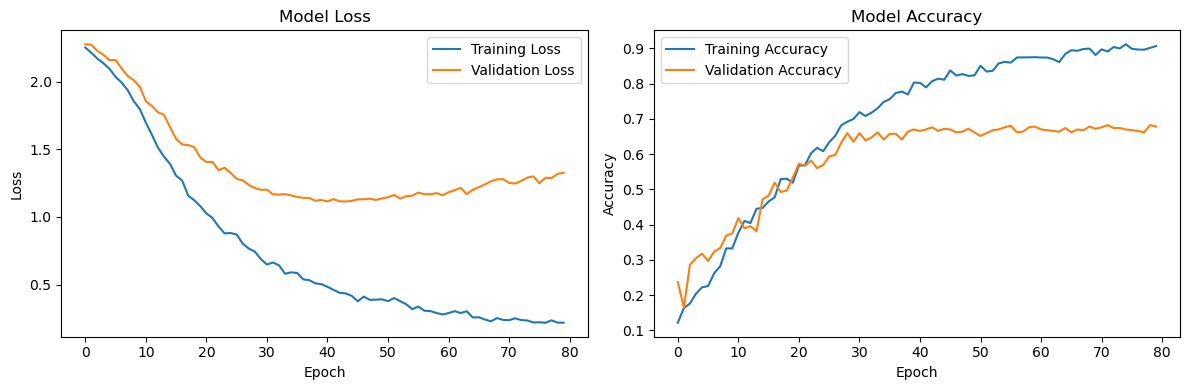

In [70]:
# Evaluate the model
test_loss_cnn_api_cw, test_accuracy_cnn_api_cw = model_cnn_api_cw.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy_cnn_api_cw:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_cnn_api_cw.history['loss'], label='Training Loss')
plt.plot(history_cnn_api_cw.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn_api_cw.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn_api_cw.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

### ResNet

In [71]:
model_resnet_cw = resnet_model()
history_resnet_cw = model_resnet_cw.fit(
    x_train, y_train,
    batch_size = 128,
    epochs = 80,
    validation_split=0.2,
    class_weight=class_weights)

Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.1715 - loss: 2.3078 - val_accuracy: 0.2536 - val_loss: 2.2292
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4150 - loss: 1.5597 - val_accuracy: 0.3072 - val_loss: 2.1563
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6407 - loss: 1.0976 - val_accuracy: 0.2474 - val_loss: 2.1071
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7363 - loss: 0.8205 - val_accuracy: 0.2289 - val_loss: 2.0834
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8497 - loss: 0.5884 - val_accuracy: 0.2062 - val_loss: 2.0676
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8818 - loss: 0.4548 - val_accuracy: 0.1670 - val_loss: 2.1250
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9268 - loss: 0.3499 - val_accuracy: 0.1588 - val_loss: 2.1874
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9296 - loss: 0.2741 - val_accuracy: 0.1608 - v

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7045 - loss: 1.2542
Test accuracy: 0.7213


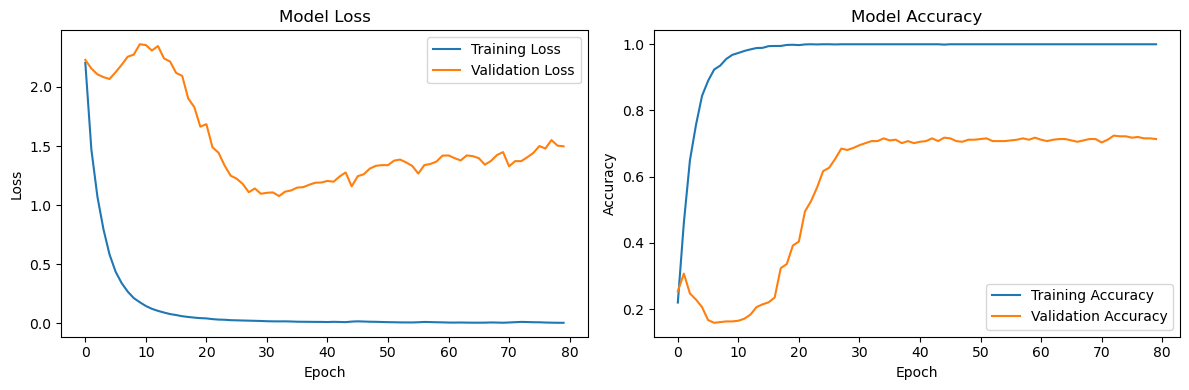

In [72]:
# Evaluate the model
test_loss_resnet_cw, test_accuracy_resnet_cw = model_resnet_cw.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy_resnet_cw:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_resnet_cw.history['loss'], label='Training Loss')
plt.plot(history_resnet_cw.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_resnet_cw.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet_cw.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

# Data augmentation

In [73]:
import numpy as np
from scipy.interpolate import interp1d

def jitter(x, sigma=0.03):
    return x + np.random.normal(loc=0., scale=sigma, size=x.shape)

def scaling(x, sigma=0.1):
    factor = np.random.normal(loc=1., scale=sigma, size=(x.shape[0], 1, x.shape[2]))
    return x * factor

def time_warp(x, sigma=0.2, knot=4):
    orig_steps = np.arange(x.shape[1])
    random_warps = np.random.normal(loc=1.0, scale=sigma, size=(x.shape[0], knot+2, x.shape[2]))
    warp_steps = (np.ones((x.shape[2], 1)) * (np.linspace(0, x.shape[1]-1., num=knot+2))).T
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        for dim in range(x.shape[2]):
            time_warp = interp1d(warp_steps[:, dim], warp_steps[:, dim] * random_warps[i, :, dim], 
                                 kind='cubic', bounds_error=False, fill_value='extrapolate')
            warped = time_warp(orig_steps)
            ret[i, :, dim] = np.interp(warped, orig_steps, pat[:, dim])
    return ret

def augment_protein_data(x_train, y_train, augment_factor=2):
    x_aug, y_aug = [], []
    
    for i in range(len(x_train)):
        # Original sequence
        x_aug.append(x_train[i])
        y_aug.append(y_train[i])
        
        # Augmented sequences
        for _ in range(augment_factor - 1):
            aug_seq = x_train[i].copy()
            
            # Apply random augmentations
            if np.random.random() < 0.7:
                aug_seq = jitter(aug_seq)
            if np.random.random() < 0.5:
                aug_seq = scaling(aug_seq[np.newaxis, ...])[0]
            if np.random.random() < 0.3:
                aug_seq = time_warp(aug_seq[np.newaxis, ...])[0]
            
            x_aug.append(aug_seq)
            y_aug.append(y_train[i])
    
    return np.array(x_aug), np.array(y_aug)

# Assuming x_train is your protein data and y_train is the corresponding labels
x_train_augmented, y_train_augmented = augment_protein_data(x_train, y_train, augment_factor=2)

# Shuffle the augmented dataset
indices = np.arange(len(x_train_augmented))
np.random.shuffle(indices)
x_train_aug = x_train_augmented[indices]
y_train_aug = y_train_augmented[indices]


class_weights_aug = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(np.argmax(y_train_aug, axis=1)),
                                        y = np.argmax(y_train_aug, axis=1)
                                    )
class_weights_aug = dict(enumerate(class_weights_aug))
print(f'Class Weights: {class_weights_aug}\n')

Class Weights: {0: 0.7168639053254438, 1: 0.427336860670194, 2: 0.45289719626168223, 3: 1.0399141630901287, 4: 0.8501754385964913, 5: 3.846031746031746, 6: 1.0816964285714286, 7: 4.106779661016949, 8: 4.038333333333333, 9: 4.106779661016949}



### DNN

In [91]:
# Create the model 
model_dnn_aug = dnn_model()

history_dnn_aug = model_dnn_aug.fit(x_train_aug, y_train_aug, 
                    epochs=80, 
                    batch_size=128, 
                    validation_split = 0.2,
                    class_weight=class_weights_aug)

Epoch 1/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1164 - loss: 2.2909 - val_accuracy: 0.2361 - val_loss: 2.1914
Epoch 2/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2402 - loss: 2.1088 - val_accuracy: 0.3309 - val_loss: 2.0876
Epoch 3/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3091 - loss: 1.9551 - val_accuracy: 0.4670 - val_loss: 1.9093
Epoch 4/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4046 - loss: 1.7076 - val_accuracy: 0.5454 - val_loss: 1.7385
Epoch 5/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4897 - loss: 1.4746 - val_accuracy: 0.6309 - val_loss: 1.5487
Epoch 6/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5629 - loss: 1.2892 - val_accuracy: 0.7330 - val_loss: 1.4012
Epoch 7/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6554 - loss: 1.1063 - val_accuracy: 0.7701 - val_loss: 1.2520
Epoch 8/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6857 - loss: 1.0232 - val_accuracy: 0.8021 - val_loss:

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step - accuracy: 0.7219 - loss: 0.9019
Test accuracy: 0.7575


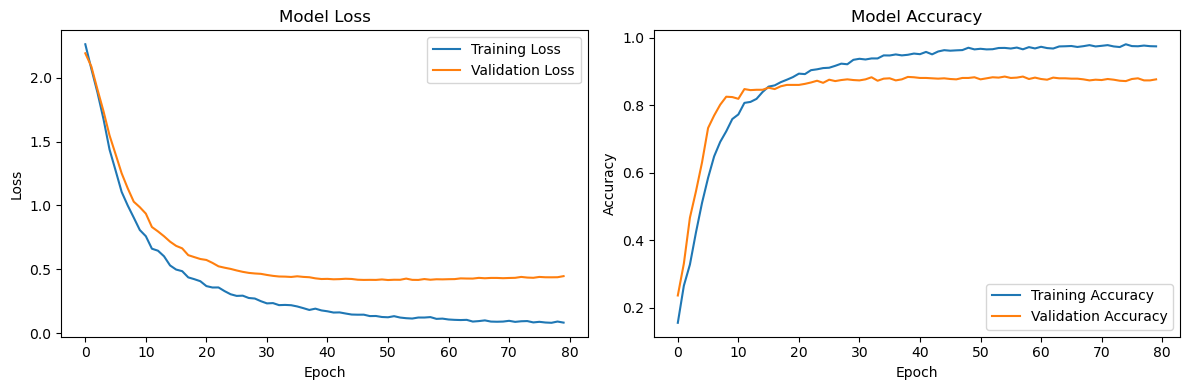

In [92]:
# Evaluate the model
test_loss_dnn_aug, test_accuracy_dnn_aug = model_dnn_aug.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy_dnn_aug:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_dnn_aug.history['loss'], label='Training Loss')
plt.plot(history_dnn_aug.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_dnn_aug.history['accuracy'], label='Training Accuracy')
plt.plot(history_dnn_aug.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

### CNN

In [76]:
model_cnn_aug = cnn_model()

history_cnn_aug = model_cnn_aug.fit(
    x_train, y_train,
    batch_size = 128,
    epochs = 80,
    validation_split=0.2,
    class_weight=class_weights_aug)

Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.1448 - loss: 2.7665 - val_accuracy: 0.1629 - val_loss: 2.2980
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.2219 - loss: 2.2586 - val_accuracy: 0.0804 - val_loss: 2.3263
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.3184 - loss: 1.9921 - val_accuracy: 0.0309 - val_loss: 2.4002
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.3743 - loss: 1.8413 - val_accuracy: 0.0227 - val_loss: 2.5039
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.4375 - loss: 1.5241 - val_accuracy: 0.0227 - val_loss: 2.6459
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.4799 - loss: 1.4991 - val_accuracy: 0.0227 - val_loss: 2.7903
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5795 - loss: 1.1995 - val_accuracy: 0.0247 - val_loss: 2.9173
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5789 - loss: 1.1006 - val_accuracy: 0.0247 - v

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7875 - loss: 0.6855
Test accuracy: 0.7969


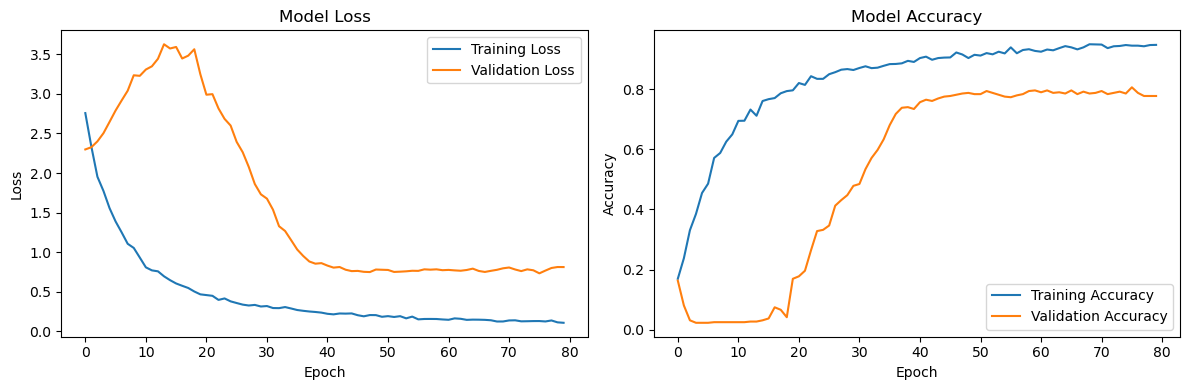

In [77]:
# Evaluate the model
test_loss_cnn_aug, test_accuracy_cnn_aug = model_cnn_aug.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy_cnn_aug:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_cnn_aug.history['loss'], label='Training Loss')
plt.plot(history_cnn_aug.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn_aug.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn_aug.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

### CNN - functional API

In [78]:
model_cnn_api_aug = cnn_api_model()
history_cnn_api_aug = model_cnn_api_aug.fit(
    x_train, y_train,
    batch_size = 128,
    epochs = 80,
    validation_split=0.2,
    class_weight=class_weights_aug)

Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.0626 - loss: 2.3301 - val_accuracy: 0.1175 - val_loss: 2.2980
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1048 - loss: 2.1877 - val_accuracy: 0.1010 - val_loss: 2.2872
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1437 - loss: 2.1923 - val_accuracy: 0.1134 - val_loss: 2.2635
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1536 - loss: 2.2076 - val_accuracy: 0.0701 - val_loss: 2.2391
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1561 - loss: 2.0658 - val_accuracy: 0.1093 - val_loss: 2.2181
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1756 - loss: 2.0507 - val_accuracy: 0.2247 - val_loss: 2.1869
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2172 - loss: 1.9652 - val_accuracy: 0.2000 - val_loss: 2.1770
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2172 - loss: 2.0006 - val_accuracy: 0.2062 - v

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6775 - loss: 1.2192 
Test accuracy: 0.6835


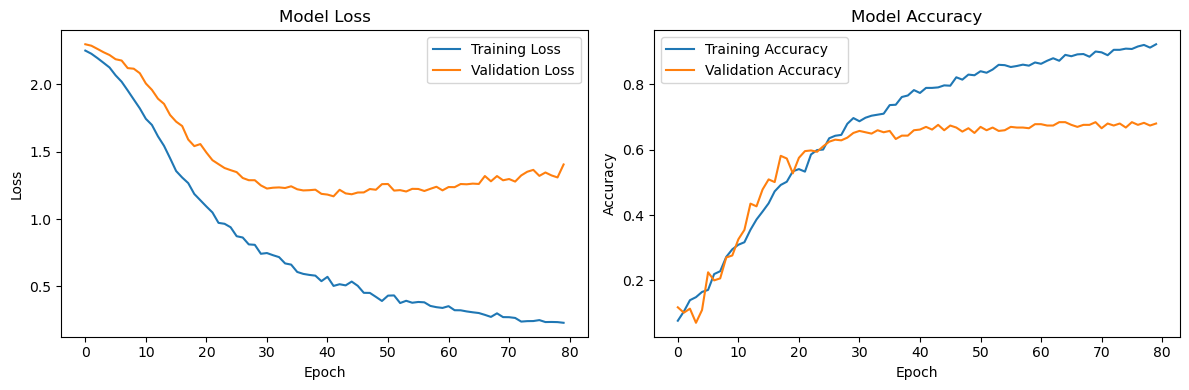

In [79]:
# Evaluate the model
test_loss_cnn_api_aug, test_accuracy_cnn_api_aug = model_cnn_api_aug.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy_cnn_api_aug:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_cnn_api_aug.history['loss'], label='Training Loss')
plt.plot(history_cnn_api_aug.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn_api_aug.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn_api_aug.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

### ResNet

In [80]:
model_resnet_aug = resnet_model()
history_resnet_aug = model_resnet_aug.fit(
    x_train, y_train,
    batch_size = 128,
    epochs = 80,
    validation_split=0.2,
    class_weight=class_weights)

Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.1796 - loss: 2.2673 - val_accuracy: 0.2598 - val_loss: 2.2350
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5186 - loss: 1.4099 - val_accuracy: 0.3278 - val_loss: 2.1559
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7350 - loss: 0.9400 - val_accuracy: 0.3299 - val_loss: 2.0865
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8391 - loss: 0.6121 - val_accuracy: 0.2887 - val_loss: 2.0313
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8732 - loss: 0.4482 - val_accuracy: 0.2165 - val_loss: 2.0198
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9170 - loss: 0.3361 - val_accuracy: 0.2804 - val_loss: 1.9690
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9428 - loss: 0.2437 - val_accuracy: 0.2722 - val_loss: 1.9337
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9515 - loss: 0.1925 - val_accuracy: 0.1959 - v

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7290 - loss: 1.3731
Test accuracy: 0.7512


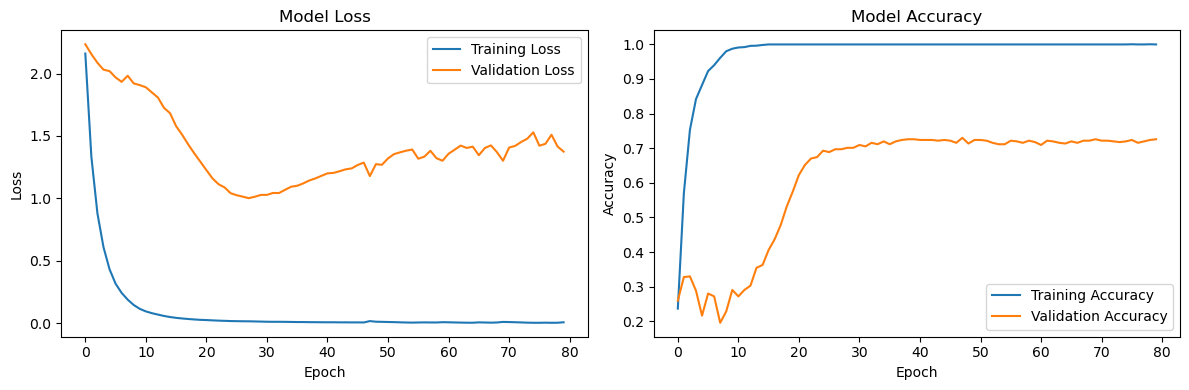

In [81]:
# Evaluate the model
test_loss_resnet_aug, test_accuracy_resnet_aug = model_resnet_aug.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy_resnet_aug:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_resnet_aug.history['loss'], label='Training Loss')
plt.plot(history_resnet_aug.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_resnet_aug.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet_aug.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

# Comparison

Table of Accuracy Values:


Method,Base,CW,Aug
Model,,,
CNN,0.8283,0.8252,0.7969
CNN_API,0.6929,0.6913,0.6835
DNN,0.7276,0.7433,0.7575
ResNet,0.7417,0.7213,0.7512


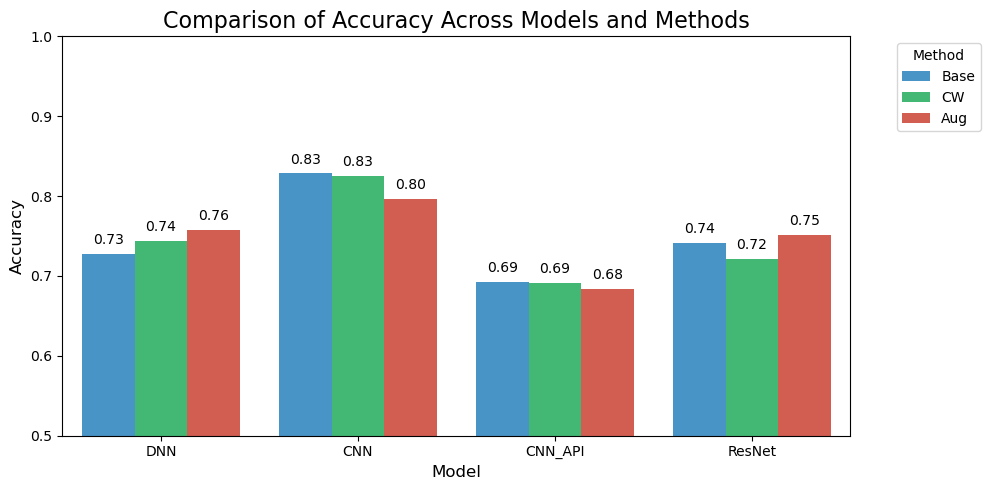

In [99]:
import pandas as pd
data = {
    'Model': ['DNN', 'DNN', 'DNN', 'CNN', 'CNN', 'CNN', 'CNN_API', 'CNN_API', 'CNN_API', 'ResNet', 'ResNet', 'ResNet'],
    'Method': ['Base', 'CW', 'Aug', 'Base', 'CW', 'Aug', 'Base', 'CW', 'Aug', 'Base', 'CW', 'Aug'],
    'Accuracy': [test_accuracy_dnn, test_accuracy_dnn_cw, test_accuracy_dnn_aug,
                 test_accuracy_cnn, test_accuracy_cnn_cw, test_accuracy_cnn_aug,
                 test_accuracy_cnn_api, test_accuracy_cnn_api_cw, test_accuracy_cnn_api_aug,
                 test_accuracy_resnet, test_accuracy_resnet_cw, test_accuracy_resnet_aug]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Pivot the table to get the desired format
pivot_df = df.pivot(index='Model', columns='Method', values='Accuracy')

# Reorder the columns
pivot_df = pivot_df[['Base', 'CW', 'Aug']]

# Display the table
print("Table of Accuracy Values:")
display(pivot_df.style.format("{:.4f}").highlight_max(axis=1))

# Function to add value labels on bars
def add_value_labels(ax, spacing=5):
    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        label = f"{y_value:.2f}"
        
        ax.annotate(label, (x_value, y_value), xytext=(0, spacing),
                    textcoords="offset points", ha='center', va='bottom')

colors = ['#3498db', '#2ecc71', '#e74c3c']

plt.figure(figsize=(10, 5))
ax = sns.barplot(x='Model', y='Accuracy', hue='Method', data=df, palette=colors)
plt.title('Comparison of Accuracy Across Models and Methods', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0.5, 1.0)  # Adjust this range based on your actual accuracy values
add_value_labels(ax)
plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()